<a href="https://colab.research.google.com/github/Ronnypetson/titanic/blob/master/produto_interno_maromba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.optim import Adam

import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt
import time
from IPython import display
from IPython.core.debugger import Pdb

def breakpoint():
    Pdb().set_trace()

device = "cuda:0" if torch.cuda.is_available() else "cpu"

%matplotlib inline

### Implement example of "Produto Interno Maromba": fitting linear transform using maromba product

#### Implementação do Tensor Maromba

In [14]:
class MTensor:
  def __init__(
      self,
      values: torch.Tensor,
      indices: torch.Tensor,
      indexer: nn.Module,
    ):
    assert values.shape == indices.shape[:-1]
    self.data = values
    self.idx = indices
    self.indexer = indexer

  def _gbmd(self, u, v, idxu, idxv) -> torch.Tensor:
    """
    'General Batch Maromba Dot'
    Shorter implementation for the 'batch maromba dot' operation.
    u: M x d_u
    v: N x d_v
    idxu: M x d_u x d_idx
    idxv: N x d_v x d_idx
    """
    m, d_u = u.shape
    n, d_v = v.shape
    d_idx = idxu.shape[-1]
    assert (m, d_u, d_idx) == idxu.shape
    assert (n, d_v, d_idx) == idxv.shape
    # uidxu: M x d_idx
    # vidxv: N x d_idx
    uidxu = torch.bmm(u.reshape(m, 1, d_u), idxu).squeeze(1)
    vidxv = torch.bmm(v.reshape(n, 1, d_v), idxv).squeeze(1)
    dot = uidxu @ vidxv.T
    return dot

  def _genidx(self, idxu, idxv):
    """
    idxu: M x d_u x d_idx
    idxv: N x d_v x d_idx
    """
    m, d_u, d_idx = idxu.shape
    n, d_v, _ = idxv.shape
    assert d_idx == idxv.shape[-1]
    # idxu_new: M x d_idx
    # idxv_new: N x d_idx
    idxu_new = (
        self.indexer(idxu.reshape(-1, d_idx))
        .reshape(m, d_u, d_idx).mean(dim=1)
    )
    idxv_new = (
        self.indexer(idxv.reshape(-1, d_idx))
        .reshape(n, d_v, d_idx).mean(dim=1)
    )
    idxu_new = idxu_new.unsqueeze(1).repeat(1, n, 1)
    idxv_new = idxv_new.unsqueeze(0).repeat(m, 1, 1)
    idx_new = idxu_new + idxv_new
    # idx_new = nn.functional.gumbel_softmax(idx_new, hard=False, dim=-1)
    idx_new = nn.functional.softmax(idx_new, dim=-1)
    return idx_new

  def _xor_idx(self, idxu, idxv):
    """
    idxu: M x d_u x d_idx
    idxv: N x d_v x d_idx
    """
    m, d_u, d_idx = idxu.shape
    n, d_v, _ = idxv.shape
    assert d_idx == idxv.shape[-1]
    # idxu: (M * d_u) x d_idx x 1
    # idxv: (N * d_v) x d_idx x 1
    idxu = idxu.reshape(m * d_u, d_idx, 1)
    idxv = idxv.reshape(n * d_v, d_idx, 1)
    # siiT: M x d_idx x d_idx
    # sjjT: N x d_idx x d_idx
    siiT = torch.bmm(idxu, idxu.permute(0, 2, 1))
    siiT = siiT.reshape(m, d_u, d_idx, d_idx).sum(dim=1)
    sjjT = torch.bmm(idxv, idxv.permute(0, 2, 1))
    sjjT = sjjT.reshape(n, d_v, d_idx, d_idx).sum(dim=1) ###
    # siiT: (M * N) x d_idx x d_idx
    # sjjT: (M * N) x d_idx x d_idx
    siiT = siiT.unsqueeze(1).repeat(1, n, 1, 1).reshape(m * n, d_idx, d_idx)
    sjjT = sjjT.unsqueeze(0).repeat(m, 1, 1, 1).reshape(m * n, d_idx, d_idx)
    # si: (M * N) x d_idx x 1
    # sj: (M * N) x d_idx x 1
    si = idxu.reshape(m, d_u, d_idx).sum(dim=1).unsqueeze(1)
    si = si.repeat(1, n, 1).reshape(m * n, d_idx, 1)
    sj = idxv.reshape(n, d_v, d_idx).sum(dim=1).unsqueeze(0)
    sj = sj.repeat(m, 1, 1).reshape(m * n, d_idx, 1)
    diag_siiT_sjjT = torch.diagonal(torch.bmm(siiT, sjjT), dim1=1, dim2=2)
    diag_siiT_sjjT = diag_siiT_sjjT.unsqueeze(-1)
    xor_idx = torch.bmm(siiT, sj) + torch.bmm(sjjT, si) - 2 * diag_siiT_sjjT
    # xor_idx = torch.bmm(siiT, sj) + torch.bmm(sjjT, si) - diag_siiT_sjjT
    xor_idx = xor_idx.reshape(m, n, d_idx) / d_u
    # xor_idx = nn.functional.softmax(xor_idx, dim=-1)
    return xor_idx

  def __matmul__(self, b):
    apre = self.data.shape[:-1]
    bpre = b.data.shape[:-1]
    d_idx = self.idx.shape[-1]
    assert d_idx == b.idx.shape[-1]
    aidx = self.idx.reshape(*((-1,) + self.idx.shape[-2:]))
    bidx = b.idx.reshape(*((-1,) + b.idx.shape[-2:]))
    mdot = self._gbmd(
        self.data.reshape(-1, self.data.shape[-1]),
        b.data.reshape(-1, b.data.shape[-1]),
        aidx,
        bidx
    )
    mdot = mdot.reshape(apre + bpre)
    # midx = self._genidx(aidx, bidx)
    midx = self._xor_idx(aidx, bidx)
    midx = midx.reshape(apre + bpre + (d_idx,))
    mans = MTensor(mdot, midx, self.indexer)
    return mans

#### Funções auxiliares

In [22]:
def y(x, W):
  """
  x: N x d_in
  W: d_out x d_in
  """
  return x @ W.T

def maromba_loss(y_true, y_pred, true_index, pred_index, debug=False):
  """
  y_true: N x d_out
  y_pred: N x d_out
  true_index: N x d_out x d_index
  pred_index: N x d_out x d_index
  """
  assert y_true.shape == y_pred.shape
  assert true_index.shape == pred_index.shape
  ###
  # index_match = (pred_index.mean(dim=0) @ true_index.mean(dim=0).T)
  # match_loss_lr = huber(y_pred, y_true @ index_match.T)
  # match_loss_rl = huber(y_true, y_pred @ index_match)
  ###
  # index_match: N x d_out x d_out
  index_match = torch.bmm(pred_index, true_index.permute(0, 2, 1))
  # y_true_match: N x 1 x d_out
  # y_pred_match: N x 1 x d_out
  y_true_match = torch.bmm(y_true.unsqueeze(1), index_match.permute(0, 2, 1))
  y_pred_match = torch.bmm(y_pred.unsqueeze(1), index_match)
  huber = nn.HuberLoss()
  match_loss_lr = huber(y_pred, y_true_match.squeeze(1))
  match_loss_rl = huber(y_true, y_pred_match.squeeze(1))
  loss = match_loss_lr + match_loss_rl
  return loss

#### Inicialização de parâmetros

In [67]:
in_dim = 2
out_dim = 3
index_dim = in_dim + out_dim # making things easier
__hidden_dim = 5 * index_dim
num_examples = 1000

# Ground-truth parameters
W_true = torch.randn((out_dim, in_dim), requires_grad=False)
W_true = W_true.float().to(device)

# Parameters to be trained
bag_values_W = nn.Parameter(torch.randn((out_dim, in_dim)))
bag_values_W = bag_values_W.float().to(device)
bag_indices_W = nn.Parameter(torch.randn((out_dim, in_dim, index_dim)))
# bag_indices_W = nn.Parameter(
#     torch.eye(index_dim)[:in_dim].unsqueeze(0).repeat(out_dim, 1, 1)
#     + torch.eye(index_dim)[in_dim:].unsqueeze(1).repeat(1, in_dim, 1)
# )
bag_indices_W = bag_indices_W.float().to(device)
###
# Indexer model to be trained
# indexer = nn.Sequential(
#     nn.Linear(index_dim, __hidden_dim),
#     # nn.Dropout(0.5),
#     nn.ReLU(),
#     nn.Linear(__hidden_dim, index_dim),
# ).to(device)
indexer = nn.Identity().to(device)
__W = MTensor(bag_values_W, bag_indices_W, indexer)
###

# Input data
values_x = 1e0 * torch.randn((num_examples, in_dim))
index_x = torch.eye(index_dim)[:in_dim]
index_x = index_x.unsqueeze(0).repeat(num_examples, 1, 1)

# Ground-truth target
y_true = y(values_x, W_true)
y_true_index = torch.eye(index_dim)[in_dim:]
y_true_index = y_true_index.unsqueeze(0).repeat(num_examples, 1, 1)

#### Treino para aproximar função f(x) = Wx

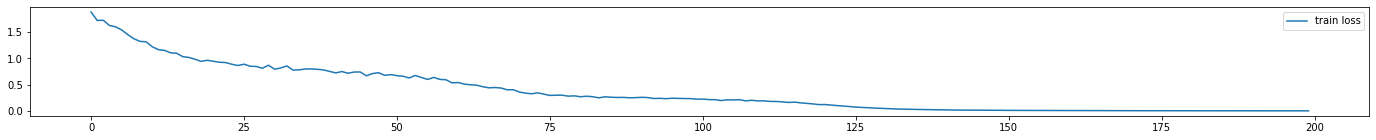

In [68]:
### TODO: Optimize optimization of index and parameters. Is it possible in the
###       general case?
###       Analyse positional encoding of input and ouput versus multi one-hot.
###       Analyse parameterized positional encoding for the learnable indices.

# opt_vectors = Adam([bag_values_W, bag_indices_W], lr=1e-2)
opt_vectors = Adam([__W.data, __W.idx], lr=1e-3) # 
# opt_vectors = Adam([__W.data], lr=1e-1)
# opt_indexer = Adam(indexer.parameters(), lr=3e-4)

num_epochs = 200
batch_size = 32
epoch_len = num_examples // batch_size

all_losses = []
for epoch in range(num_epochs):
  epoch_losses = []
  for _ in range(epoch_len):
    batch_idx = np.random.choice(num_examples, batch_size)
    batch_x = values_x[batch_idx].float().to(device)
    batch_x_index = index_x[batch_idx].float().to(device)
    ###
    __batch_x = MTensor(batch_x, batch_x_index, indexer)
    ###
    batch_y_true = y_true[batch_idx].float().to(device)
    batch_y_true_index = y_true_index[batch_idx].float().to(device)
    # y_pred_val, y_pred_index = gbmd(
    #     batch_x, bag_values_W, batch_x_index, bag_indices_W, indexer
    # )
    ###
    __W_idx = __W.idx.clone()
    __W_idx[:, :, :in_dim] = nn.functional.softmax(__W_idx.clone()[:, :, :in_dim], dim=-1)
    __W_idx[:, :, in_dim:] = nn.functional.softmax(__W_idx.clone()[:, :, in_dim:], dim=-1)
    __W2 = MTensor(__W.data, __W_idx, indexer)
    # __y_pred = __batch_x @ __W
    __y_pred = __batch_x @ __W2
    y_pred_val, y_pred_index = __y_pred.data, __y_pred.idx
    ###
    loss = maromba_loss(
        batch_y_true, y_pred_val, batch_y_true_index, y_pred_index
    )
    opt_vectors.zero_grad()
    # opt_indexer.zero_grad()
    loss.backward()
    opt_vectors.step()
    # opt_indexer.step()
    epoch_losses.append(loss.item())
  all_losses.append(np.mean(epoch_losses))
  df_train = pd.DataFrame({
      "train loss": all_losses,
  })
  display.clear_output(wait=True)
  df_train.plot(figsize=(24, 2))
  plt.show()

In [69]:
print(np.mean(all_losses[-5:]))
# y_pred_index.shape, batch_y_true_index.shape
index_match = (y_pred_index[0] @ batch_y_true_index[0].T)
print(index_match.sum(dim=-1))
print(index_match.sum(dim=0))

0.0032892041539232574
tensor([1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)
tensor([0.9742, 1.0088, 1.0170], grad_fn=<SumBackward1>)


In [63]:
(W_true - __W.data).abs().mean()

tensor(0.4143, grad_fn=<MeanBackward0>)

In [70]:
idxs = torch.argmax(y_pred_index[0], dim=-1) - in_dim
(batch_y_true[0][idxs] - y_pred_val[0]).abs().mean()

tensor(0.0109, grad_fn=<MeanBackward0>)

In [71]:
batch_y_true[0][idxs], y_pred_val[0]

(tensor([-0.3895,  2.2035,  0.2989]),
 tensor([-0.3926,  2.2035,  0.2693], grad_fn=<SelectBackward0>))

In [72]:
y_pred_index[0]

tensor([[0.1969, 0.1969, 0.0076, 0.0086, 0.9838],
        [0.2632, 0.2632, 0.9517, 0.0394, 0.0090],
        [0.0768, 0.0768, 0.0149, 0.9608, 0.0242]], grad_fn=<SelectBackward0>)